# salvo_eval_broadband_albedo

Notebook for evaluating the accuracy of the SALVO broadband albedo measurements

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import datetime
import xarray as xr
from scipy.stats import linregress, norm
import warnings
import datetime

from modules.salvoimport import load_salvo_data_str, load_gml_albedo, preprocess_rap
from modules.salvoproc import line_date_agg

In [2]:
# Load SALVO data
salvo_data_root_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                                    "SALVO", "data", "salvo-2024-backup", "SALVO-2024-20240619-1305")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df = load_salvo_data_str(salvo_data_root_path, dates=None,insts=['kz-mobile', 'magnaprobe'], sites=['arm', 'beo', 'ice'])

In [3]:
# Load NSA qcrad data
nsa_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsaqcrad", "*.cdf")
ds_nsa = xr.open_mfdataset(nsa_path)
varnames = ['BestEstimate_down_short_hemisp', 'up_short_hemisp',
            'down_long_hemisp', 'up_long_hemisp',
            'Temp_Air', 'wind_speed']
da_list = []
for varname in varnames:
    da_list.append(ds_nsa[varname].where(ds_nsa['qc_'+varname]==0))
df_nsa = xr.merge(da_list).to_dataframe()
df_nsa['timestamp_utc'] = df_nsa.index.tz_localize('UTC')
df_nsa.set_index('timestamp_utc', inplace=True)
df_nsa['albedo'] = df_nsa['up_short_hemisp']/df_nsa['BestEstimate_down_short_hemisp']

In [4]:
# Load GML
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "gml_albedo_rack")
df_gml = load_gml_albedo(dir_path)

df_gml['incident_bestestimate_W_m2'] = df_gml['direct_solar_W_m2']*np.cos(df_gml['zen']*np.pi/180) + df_gml['diffuse_solar_W_m2']
df_gml['incident_bestestimate_W_m2_qc'] = df_gml['direct_solar_W_m2_qc'] + df_gml['diffuse_solar_W_m2_qc']
df_gml['albedo'] = df_gml['reflected_solar_W_m2'] / df_gml['incident_bestestimate_W_m2']
df_gml['diffuse_frac'] = df_gml['diffuse_solar_W_m2']/df_gml['incident_bestestimate_W_m2']

In [5]:
# Load uncertainty measurements
df_unc = pd.read_csv(os.path.join(salvo_data_root_path, '20240617-radiometer-uncertainty', 'kz-mobile',
                                  'salvo_beo_uncertainty_kz-mobile_20240617.a1.csv'), 
                                  usecols=['date_akdt', 'timestamp_akdt', 'incident_solar_W_m2', 
                                                 'reflected_solar_W_m2', 'site', 'location',
                                                 'operator_distance_m', 'repetition', 'operator_pants', 'albedo',
                                          'notes'],
                             dtype={'position': 'float64', 'timestamp_akdt':'str'})

In [6]:
# Filter to just broadband uncertainty measurements (the other measurements were to help with ASD uncertainty)
df_unc = df_unc[df_unc['operator_distance_m'].notnull()].copy()

In [7]:
df_unc['timestamp_akdt'] = df_unc['timestamp_akdt'].apply(lambda x: x[:-2]+':'+x[-2:])
df_unc['timestamp_akdt'] = pd.to_datetime(df_unc['date_akdt']+'T'+df_unc['timestamp_akdt']+'-0800', utc=False)
df_unc.drop(columns=['date_akdt'], inplace=True)

## Explore uncertainty caused by operator presence

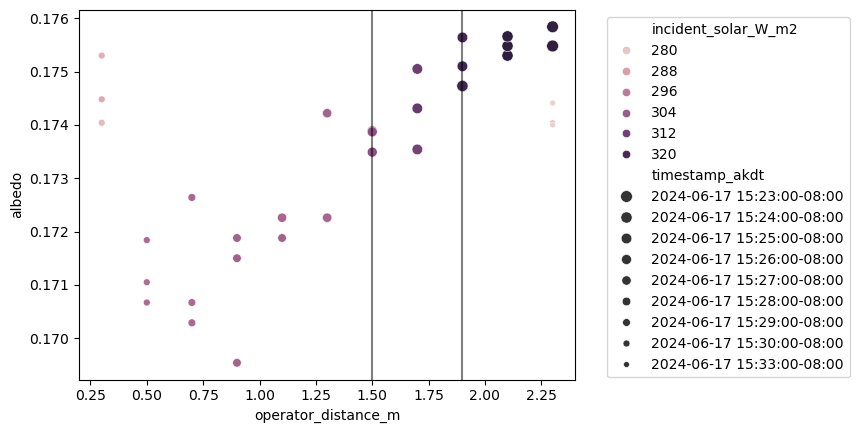

In [8]:
ax = sns.scatterplot(x='operator_distance_m', y='albedo', 
                     hue='incident_solar_W_m2', size='timestamp_akdt', 
                     data=df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1.0))
ax.axvline(x=1.5, c='k', alpha=0.5)
ax.axvline(x=1.9, c='k', alpha=0.5)


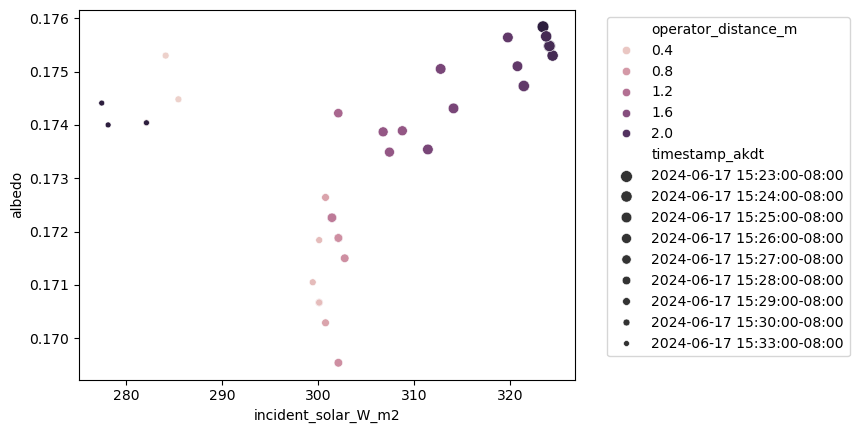

In [9]:
ax = sns.scatterplot(hue='operator_distance_m', y='albedo', 
                     x='incident_solar_W_m2', size='timestamp_akdt', 
                     data=df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1.0))

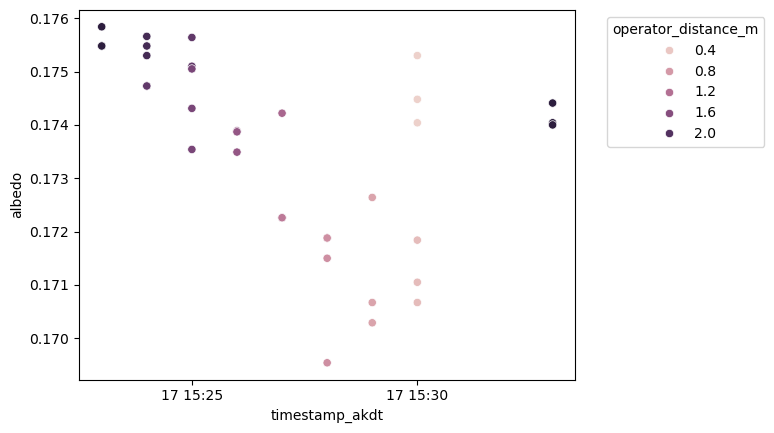

In [10]:
ax = sns.scatterplot(hue='operator_distance_m', y='albedo', x='timestamp_akdt', 
                     data=df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1.0))

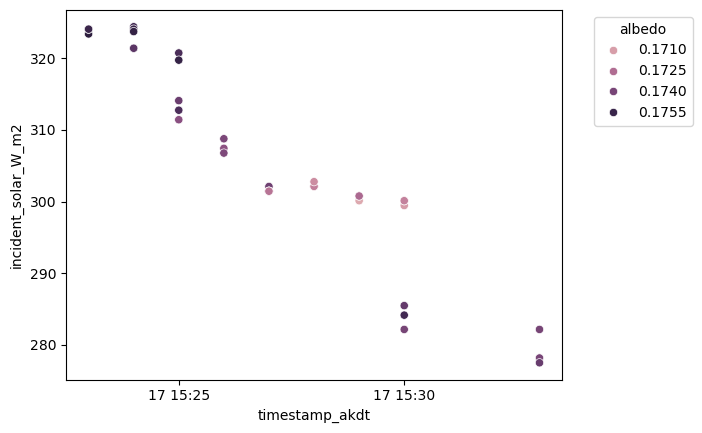

In [11]:
ax = sns.scatterplot(hue='albedo', y='incident_solar_W_m2', x='timestamp_akdt', 
                     data=df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna()])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1.0))

In [12]:
df_unc_2_3m = df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna() & (df_unc.operator_distance_m==2.3)]
df_unc_2_3m

,timestamp_akdt,incident_solar_W_m2,reflected_solar_W_m2,albedo,site,location,operator_distance_m,operator_pants,repetition,notes
0,2024-06-17 15:23:00-08:00,323.42,56.870,0.17584,beo,uncertainty_test,2.3,black,1.0,NaN
1,2024-06-17 15:23:00-08:00,324.09,56.870,0.17548,beo,uncertainty_test,2.3,black,2.0,NaN
2,2024-06-17 15:23:00-08:00,324.09,56.870,0.17548,beo,uncertainty_test,2.3,black,3.0,NaN
37,2024-06-17 15:33:00-08:00,282.12,49.100,0.17404,beo,uncertainty_test,2.3,black,1.0,NaN
38,2024-06-17 15:33:00-08:00,278.13,48.393,0.17400,beo,uncertainty_test,2.3,black,2.0,NaN
39,2024-06-17 15:33:00-08:00,277.46,48.393,0.17441,beo,uncertainty_test,2.3,black,3.0,NaN


In [13]:
df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna() & (df_unc.operator_distance_m.isin([1.5, 1.7, 1.9, 2.1, 2.3]))
    ][['operator_distance_m', 'albedo']].max()

operator_distance_m    2.30000
albedo                 0.17584
dtype: float64

In [14]:
df_unc[(df_unc.operator_pants=='black') & df_unc.notes.isna() & (df_unc.operator_distance_m.isin([2.3]))
    ][['operator_distance_m', 'albedo']]
print(df_unc.loc[[0,1,2]]['albedo'].max() - df_unc.loc[[37,38,39]]['albedo'].min())


0.0018400000000000083


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_7900\4198688481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Time (AKDT)'] = df_temp.timestamp_akdt.dt.strftime('%H:%M')


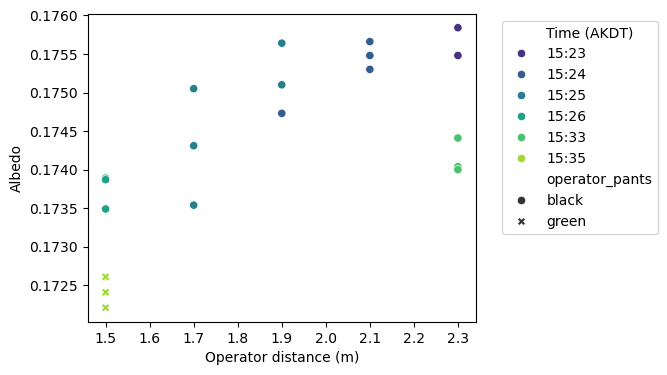

In [15]:
df_temp = df_unc[df_unc.notes.isna() 
            & (df_unc.operator_distance_m.isin([1.5, 1.7, 1.9, 2.1, 2.3]))]

df_temp['Time (AKDT)'] = df_temp.timestamp_akdt.dt.strftime('%H:%M')


f, axs = plt.subplots(1,1, sharey=True, figsize=(5,4))

sns.scatterplot(x='operator_distance_m', y='albedo', hue='Time (AKDT)',
                style='operator_pants',
            data=df_temp,
               palette='viridis',
               ax=axs)
sns.move_legend(axs, loc='upper left', bbox_to_anchor=(1.05, 1.0))
axs.set_xlabel('Operator distance (m)')
axs.set_ylabel('Albedo')

f.savefig(os.path.join('..', 'figures', 'salvo_kz_operator_impacts.png'), bbox_inches='tight')

In [16]:
df_unc[df_unc.notes.isna() & (df_unc.operator_distance_m==1.5)
    ][['operator_pants', 'albedo']].groupby('operator_pants').mean()

,albedo
operator_pants,
black,0.17375
green,0.17241


In [17]:
print('hanging datalogger albedo:')
print(df_unc[df_unc.notes.isna() & (df_unc.operator_distance_m==2.3)]['albedo'].mean())
print('holding datalogger albedo:')
print(df_unc[df_unc.notes=="holding datalogger so it doesn't hang"]['albedo'].mean())

hanging datalogger albedo:
0.17487499999999997
holding datalogger albedo:
0.17497666666666667


## Compare with GML and NSA measurements

In [18]:
# Compare arm incident with GML incident
# Shifting the field obs forward 1 minute slightly improves alignment
offset = pd.Timedelta(1, 'min')

df_temp = df_gml.query("incident_solar_W_m2_qc==0")
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp[['incident_solar_W_m2', 'incident_bestestimate_W_m2', 'direct_solar_W_m2', 'diffuse_solar_W_m2', 'zen']]
df_temp2 = df.xs(('arm', 'incident_solar_W_m2'), level=('site', 'variable')).droplevel(['location', 'position', 'repetition', 'wavelength'])
df_temp2 = df_temp2.rename(columns={'value': 'salvo_arm_incident'})
df_temp2 = df_temp2.reset_index()
df_temp2['timestamp_akdt'] += offset
df_temp2 = df_temp2.set_index('timestamp_akdt')
df_temp3 = df_nsa.copy()
df_temp3.index = df_temp3.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp3 = df_temp3['BestEstimate_down_short_hemisp'].rename('nsa_incident')

df_comp = df_temp2.join(df_temp)
df_comp = df_comp.join(df_temp3)
df_comp['diff_gml_be'] = df_comp['salvo_arm_incident'] - df_comp['incident_bestestimate_W_m2']
df_comp['diff_nsa'] = df_comp['salvo_arm_incident'] - df_comp['nsa_incident']

df_comp['diff_gml'] = df_comp['salvo_arm_incident'] - df_comp['incident_solar_W_m2']
df_comp['diff_gml_be'] = df_comp['salvo_arm_incident'] - df_comp['incident_bestestimate_W_m2']
df_comp['diff_nsa'] = df_comp['salvo_arm_incident'] - df_comp['nsa_incident']
df_comp['diff_gml_nsa'] = df_comp['incident_bestestimate_W_m2'] - df_comp['nsa_incident']

df_comp['diffuse_frac'] = df_comp['diffuse_solar_W_m2']/df_comp['incident_bestestimate_W_m2']

df_comp['mean_incident_W_m2'] = df_comp.salvo_arm_incident + df_comp.incident_bestestimate_W_m2 + df_comp.nsa_incident


In [19]:
df_comp['diff_gml_be'].describe()

count    628.000000
mean       0.212652
std       36.644248
min     -239.690515
25%       -6.650266
50%        2.900666
75%        8.794934
max      209.964807
Name: diff_gml_be, dtype: float64

In [20]:
df_comp['diff_nsa'].describe()

count    628.000000
mean      -1.420497
std       41.002564
min     -428.670264
25%       -8.826814
50%       -0.777054
75%       10.582272
max      168.489025
Name: diff_nsa, dtype: float64

In [21]:
df_comp['diff_gml_nsa'].describe()

count    628.000000
mean      -1.633150
std       29.829374
min     -208.216921
25%       -6.098053
50%       -1.296730
75%        5.478767
max      198.640625
Name: diff_gml_nsa, dtype: float64

In [22]:
# Median Absolute Deviation
print('Diff NSA Median Absolute Deviation:')
print(df_comp['diff_gml_be'].abs().median())
print('equivalent St. Dev. for normal distribution:')
print(df_comp['diff_gml_be'].abs().median()*1.4826)

Diff NSA Median Absolute Deviation:
7.903755863385783
equivalent St. Dev. for normal distribution:
11.71810844305576


In [23]:
# Median Absolute Deviation
print('Diff GML NSA Median Absolute Deviation:')
print(df_comp['diff_gml_nsa'].abs().median())
print('equivalent St. Dev. for normal distribution:')
print(df_comp['diff_gml_nsa'].abs().median()*1.4826)

Diff GML NSA Median Absolute Deviation:
6.010226363144625
equivalent St. Dev. for normal distribution:
8.91076160599822


Text(0.5, 0, 'salvo-gml incident (W/m2')

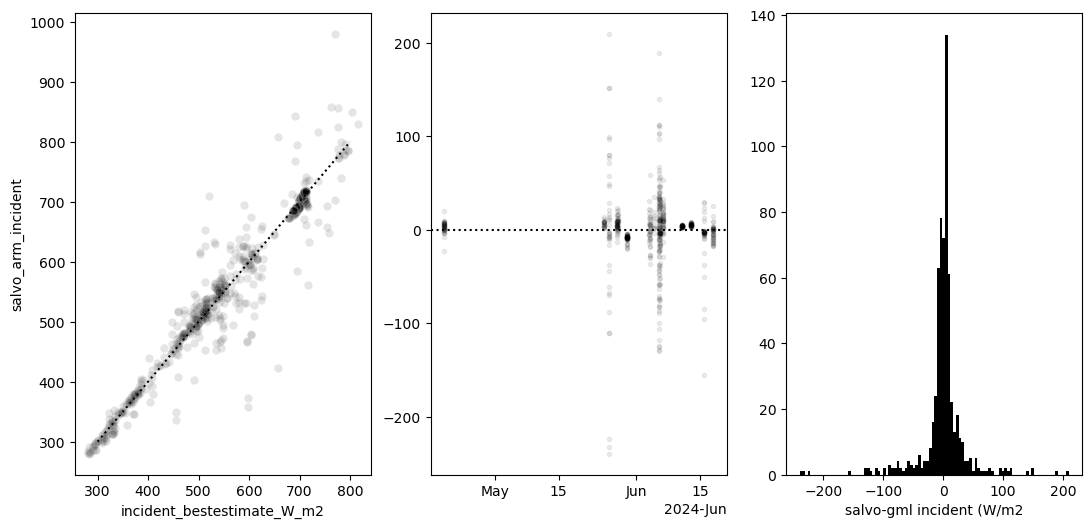

In [24]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='incident_bestestimate_W_m2', y='salvo_arm_incident', ax=axs[0], alpha=0.1, c='k')
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_gml_be'], marker='.', linestyle='', alpha=0.07, c='k')
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_gml_be'], bins=100, fc='k')
axs[2].set_xlabel('salvo-gml incident (W/m2')

Text(0.5, 0, 'salvo-nsa incident (W/m2')

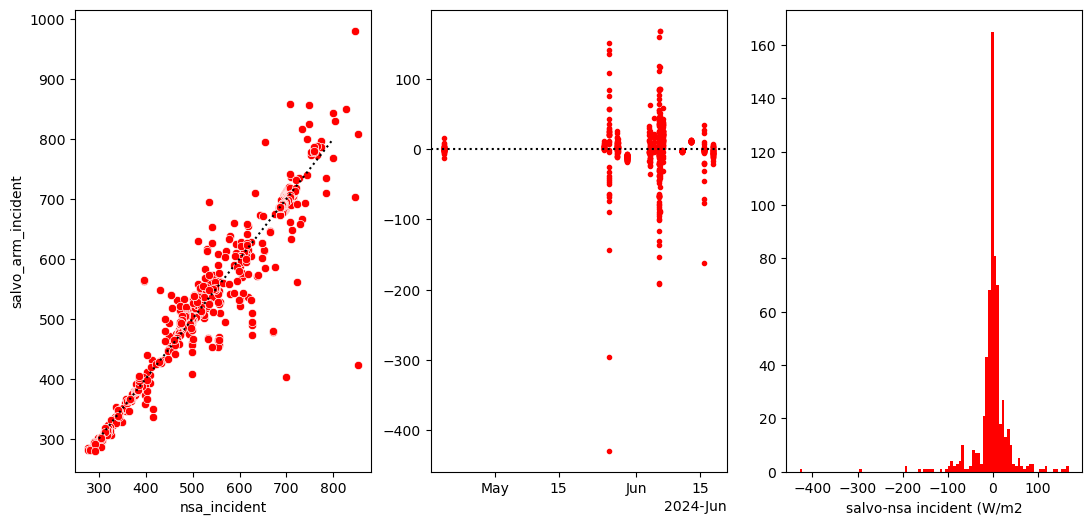

In [25]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='nsa_incident', y='salvo_arm_incident', ax=axs[0], color='r')
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_nsa'], marker='.', linestyle='', color='r')
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_nsa'], bins=100, color='r')
axs[2].set_xlabel('salvo-nsa incident (W/m2')

Text(0.5, 0, 'gml-nsa incident (W/m2')

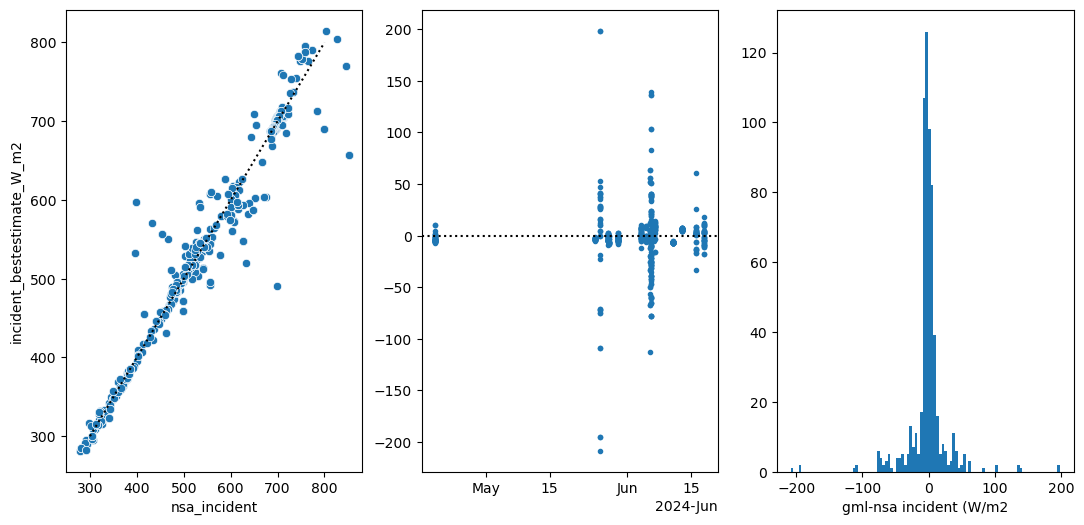

In [26]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='nsa_incident', y='incident_bestestimate_W_m2', ax=axs[0])
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_gml_nsa'], marker='.', linestyle='')
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_gml_nsa'], bins=100)
axs[2].set_xlabel('gml-nsa incident (W/m2')

In [27]:
df_comp['diff_gml_nsa'].groupby(df_comp.index.date).std()

2024-04-19     3.938224
2024-05-24     1.094270
2024-05-25    83.038427
2024-05-27     3.015690
2024-05-29     2.328462
2024-06-03     4.713886
2024-06-04     5.507422
2024-06-05    41.055364
2024-06-06     6.452998
2024-06-10     0.471615
2024-06-12     0.957541
2024-06-15    13.210465
2024-06-17     8.311048
Name: diff_gml_nsa, dtype: float64

June 5, was partly cloudy with highly variable sky conditions and a large number of measurements (155) were made in an attempt to test whether we could collect acceptable ASD data under those conditions. These conditions fell outside S.O.P. so exclude them from uncertainty analysis.
May 25 was also rapidly varying cloud conditions, although this wasn't fully appreciated at the time measurements were being made. We'll exclude it as well.

In [28]:
df_comp_clean = df_comp[np.isin(df_comp.index.date, [datetime.date(2024, 5, 25), datetime.date(2024, 6, 5)], invert=True)]

In [29]:
df_comp_clean['diff_gml_be'].describe()

count    432.000000
mean       1.031919
std       14.735469
min     -155.426608
25%       -4.447790
50%        3.243192
75%        6.849179
max       58.974658
Name: diff_gml_be, dtype: float64

In [30]:
df_comp_clean['diff_nsa'].describe()

count    432.000000
mean       0.607131
std       15.482984
min     -161.939873
25%       -5.120227
50%       -0.534521
75%        8.113642
max       62.541526
Name: diff_nsa, dtype: float64

In [31]:
df_comp_clean['diff_gml_nsa'].describe()

count    432.000000
mean      -0.424788
std        6.871957
min      -33.282500
25%       -5.024916
50%       -1.507589
75%        4.202983
max       60.339739
Name: diff_gml_nsa, dtype: float64

In [32]:
df_comp['diff_gml_be'].abs().median()

7.903755863385783

In [33]:
df_comp_clean['diff_gml_be'].abs().median()

6.021102769004671

In [34]:
df_comp['diff_nsa'].abs().median()

9.645756835937505

In [35]:
df_comp_clean['diff_nsa'].abs().median()

6.650683593749989

In [36]:
(df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2']).abs().median()

0.003571596073010932

In [77]:
(df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2']).std()

0.00903568332767572

In [37]:
(df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2']).abs().median()

0.002926420555622796

In [78]:
(df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2']).std()

0.004552483131610922

In [108]:
imp_std_gml_ratio = (df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2']).abs().median()*1.4826
std_gml_ratio = (df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2']).std()
mn_gml_ratio = (df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2']).mean()
imp_std_gml_nsa_ratio = (df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2']).abs().median()*1.4826
std_gml_nsa_ratio = (df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2']).std()
mn_gml_nsa_ratio = (df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2']).mean()
imp_var_gml_ratio = (imp_std_gml_ratio)**2
imp_var_gml_nsa_ratio = (imp_std_gml_nsa_ratio)**2
var_gml_ratio = std_gml_ratio**2
var_gml_nsa_ratio = std_gml_nsa_ratio**2

print('Diff GML Best Estimate implied variance from MAD:')
print(imp_var_gml_ratio)
print('Diff GML-NSA implied variance from MAD:')
print(imp_var_gml_nsa_ratio)

print('Diff GML Best Estimate variance:')
print(var_gml_ratio)
print('Diff GML-NSA variance:')
print(var_gml_nsa_ratio)


print('implied MAD of residual:')
imp_mad_resid = ((imp_var_gml_ratio - imp_var_gml_nsa_ratio)**.5)/1.4826
print(imp_mad_resid)

print('STD of residual:')
std_resid = (var_gml_ratio - var_gml_nsa_ratio)**.5
print(std_resid)

print('implied Est. Confidence interval +- of albedo:')
print(2*imp_mad_resid*1.4826*(2**.5))

Diff GML Best Estimate implied variance from MAD:
2.803965495946091e-05
Diff GML-NSA implied variance from MAD:
1.8824414146074546e-05
Diff GML Best Estimate variance:
8.164357319803699e-05
Diff GML-NSA variance:
2.072510266360199e-05
implied MAD of residual:
0.00204752563851481
STD of residual:
0.007805028541551594
implied Est. Confidence interval +- of albedo:
0.008586147361132985


In [39]:
(df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2']).abs().quantile([0.5, 0.75, 0.95])

0.50    0.003572
0.75    0.006834
0.95    0.017278
dtype: float64

In [40]:
(df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2']).abs().quantile([0.5, 0.75, 0.95])

0.50    0.002926
0.75    0.004052
0.95    0.008912
dtype: float64

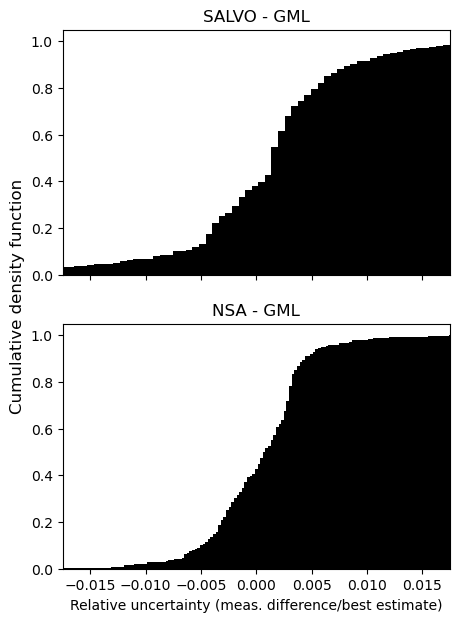

In [76]:
# Create figure comparing normalized incident distributions
f, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 7))

cts, bins, _ = axs[0].hist(df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2'], bins=200, color='k',
                          density=True, cumulative=True)
#axs[0].plot(bins, norm.cdf(bins, loc=mn_gml_ratio, scale=std_gml_ratio), c='r')
#axs[0].plot(bins, norm.cdf(bins, loc=mn_gml_ratio, scale=
#                           (df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2']).std()),
#            color='b')
axs[0].set_title('SALVO - GML')

cts, bins, _ = axs[1].hist(-1*df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2'], bins=200, color='k',
                          density=True, cumulative=True)
#axs[1].plot(bins, norm.cdf(bins, loc=mn_gml_nsa_ratio, scale=std_gml_nsa_ratio), c='r')
#axs[1].plot(bins, norm.cdf(bins, loc=mn_gml_ratio, scale=
#                           (df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2']).std()),
#            color='b')
axs[1].set_xlim([-0.0175, 0.0175])
axs[1].set_title('NSA - GML')

axs[1].set_xlabel('Relative uncertainty (meas. difference/best estimate)')
f.supylabel('Cumulative density function')
f.savefig(os.path.join('..', 'figures', 'salvo_arm_inc_err.png'), bbox_inches='tight')

In [72]:
df_comp_clean.sort_values('diff_gml_be')

,salvo_arm_incident,incident_solar_W_m2,incident_bestestimate_W_m2,direct_solar_W_m2,diffuse_solar_W_m2,zen,nsa_incident,diff_gml_be,diff_nsa,diff_gml,diff_gml_nsa,diffuse_frac,mean_incident_W_m2
timestamp_akdt,,,,,,,,,,,,,
2024-06-15 14:25:00-08:00,560.93,716.356608,716.356608,842.9,151.8,47.95,722.869873,-155.426608,-161.939873,-155.426608,-6.513265,0.211906,2000.156481
2024-06-15 14:18:00-08:00,657.53,753.426302,753.426302,815.4,207.5,47.97,727.910767,-95.896302,-70.380767,-95.896302,25.515535,0.275408,2138.867068
2024-06-15 14:17:00-08:00,632.55,717.673291,717.673291,738.4,223.3,47.97,708.865295,-85.123291,-76.315295,-85.123291,8.807995,0.311144,2059.088586
2024-06-15 14:22:00-08:00,660.86,711.925668,711.925668,802.1,174.8,47.96,706.517761,-51.065668,-45.657761,-51.065668,5.407907,0.245531,2079.303430
2024-06-15 14:20:00-08:00,671.53,709.401079,709.401079,726.8,222.7,47.96,649.061340,-37.871079,22.468660,-37.871079,60.339739,0.313927,2029.992420
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03 13:29:00-08:00,516.47,485.824658,485.824658,0.5,485.5,49.51,484.009796,30.645342,32.460204,30.645342,1.814862,0.999332,1486.304454
2024-06-06 14:32:00-08:00,479.61,446.609114,446.609114,5.3,443.1,48.54,440.614075,33.000886,38.995925,33.000886,5.995039,0.992143,1366.833189
2024-06-04 15:38:00-08:00,493.05,457.818246,457.818246,2.2,456.4,49.86,448.743286,35.231754,44.306714,35.231754,9.074960,0.996902,1399.611533


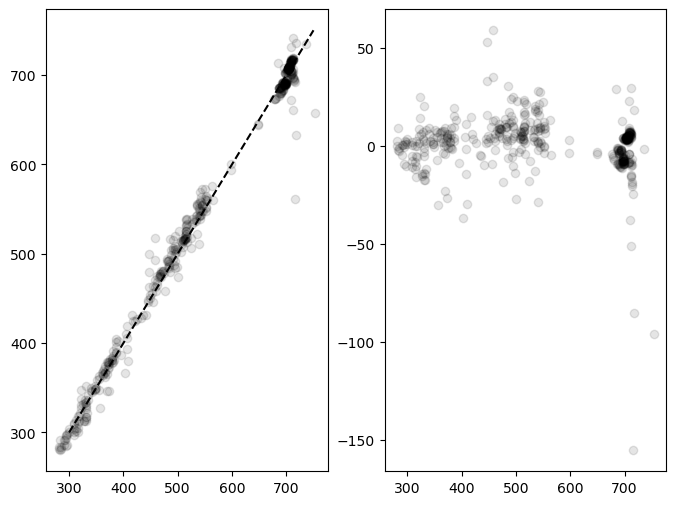

In [71]:
f, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].scatter("incident_bestestimate_W_m2", "salvo_arm_incident", data=df_comp_clean, c='k', alpha=0.1)
axs[0].plot([300, 750], [300, 750], 'k--')
axs[1].scatter("incident_bestestimate_W_m2", "diff_gml_be", data=df_comp_clean, c='k', alpha=0.1)

In [43]:
df_comp_clean['diff_gml_be'].mean()

1.0319192137685043

In [44]:
df_comp_clean['diff_nsa'].mean()

0.6071308757640698

In [45]:
df_comp_clean['diff_gml_nsa'].mean()

-0.42478833800443494

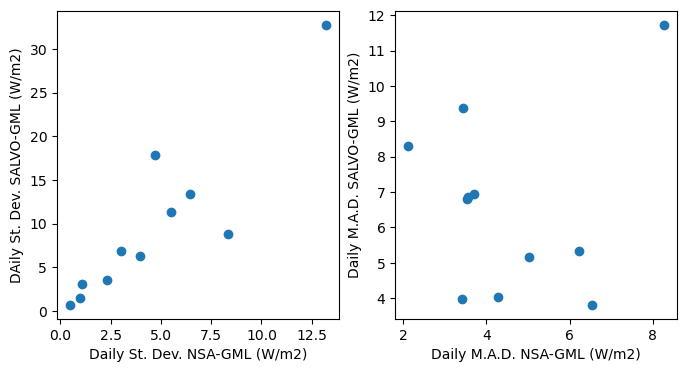

In [112]:
# Compare difference as a function of gml nsa difference
df_date_akdt = df_comp_clean.reset_index()
df_date_akdt['date_akdt'] = df_date_akdt.timestamp_akdt.dt.date
df_temp = df_date_akdt.groupby('date_akdt')[['diff_gml_be', 'diff_gml_nsa']].std().reset_index()

df_temp_abs = df_date_akdt.copy()
df_temp_abs['diff_gml_be'] = np.abs(df_temp_abs['diff_gml_be'])
df_temp_abs['diff_gml_nsa'] = np.abs(df_temp_abs['diff_gml_nsa'])
df_temp_abs = df_temp_abs.groupby('date_akdt')[['diff_gml_be', 'diff_gml_nsa']].median().reset_index()

f, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].scatter(x='diff_gml_nsa', y='diff_gml_be', data=df_temp)
#axs[0].plot([0, 35], [0, 35], 'k--')
axs[0].set_xlabel('Daily St. Dev. NSA-GML (W/m2)')
axs[0].set_ylabel('DAily St. Dev. SALVO-GML (W/m2)')

axs[1].scatter(x='diff_gml_nsa', y='diff_gml_be', data=df_temp_abs)
axs[1].set_xlabel('Daily M.A.D. NSA-GML (W/m2)')
axs[1].set_ylabel('Daily M.A.D. SALVO-GML (W/m2)')

f.savefig(os.path.join('..', 'figures', 'salvo_arm_daily_std_mad.png'), bbox_inches='tight')

In [48]:
df_temp_abs

,date_akdt,diff_gml_be,diff_gml_nsa
0,2024-04-19,4.024840,4.282394
1,2024-05-24,6.791360,3.540452
2,2024-05-27,6.849179,3.553748
3,2024-05-29,8.301084,2.113306
4,2024-06-03,9.377436,3.439938
5,2024-06-04,6.958180,3.690675
6,2024-06-06,11.732427,8.275947
7,2024-06-10,3.813509,6.549181
8,2024-06-12,5.342865,6.236248
9,2024-06-15,3.962949,3.402281


In [49]:
def plot_date_ts(date, ax, df, df_gml, df_nsa, buf_min=5):
    start = pd.Timestamp(date+" 00:00:00-0800")
    end = pd.Timestamp(date+" 23:59:59-0800")
    
    df_temp = df.xs((slice(start, end), 'arm', 'incident_solar_W_m2'), 
                    level=('timestamp_akdt', 'site', 'variable'), 
                    drop_level=False).reset_index()
    # Shifting the field obs forward 1 minute slightly improves alignment
    offset = pd.Timedelta(1, 'min')
    df_temp['timestamp_akdt'] += offset
    
    buf = pd.Timedelta(minutes=buf_min)
    start = df_temp.timestamp_akdt.min() - buf
    end = df_temp.timestamp_akdt.max() + buf
    
    # Plot 
    ax.plot('timestamp_akdt', 'value', 'b+', data=df_temp, label='SALVO')
    ax.plot(df_nsa.loc[slice(start,end)]['BestEstimate_down_short_hemisp'], 'r', label='NSA')
    ax.plot(df_gml.loc[slice(start,end)]['incident_bestestimate_W_m2'], 'k', label='GML', alpha=0.5)
    
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_ylabel('Shortwave incident (W/m2)')
    ax.set_xlabel('Time (UTC)')
    ax.legend()

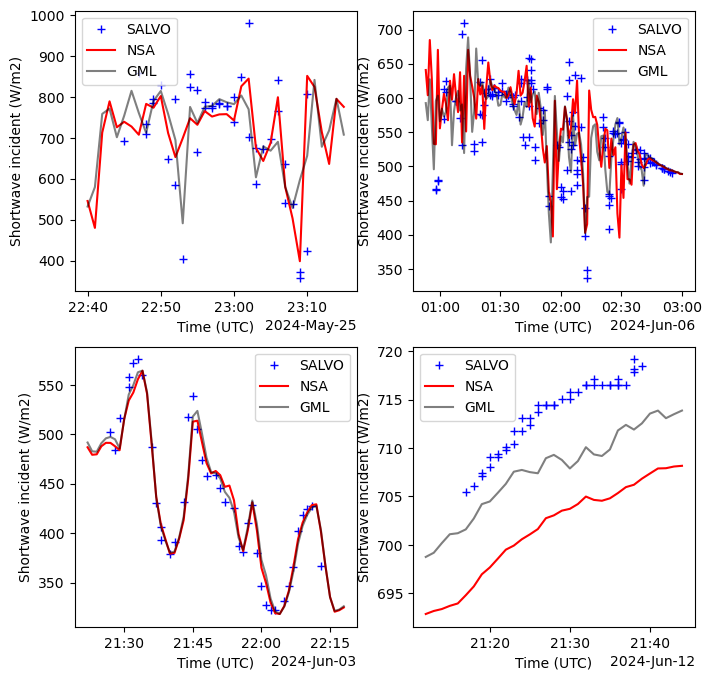

In [50]:
f, axs = plt.subplots(2,2, figsize=(8,8))

plot_date_ts('2024-05-25', axs[0,0], df, df_gml, df_nsa)

plot_date_ts('2024-06-03', axs[1,0], df, df_gml, df_nsa)

plot_date_ts('2024-06-05', axs[0,1], df, df_gml, df_nsa)

plot_date_ts('2024-06-12', axs[1,1], df, df_gml, df_nsa)

f.savefig(os.path.join('..', 'figures', 'salvo_example_incident.png'), bbox_inches='tight')

## Explore repeatability

In [52]:
df_date_akdt = df.reset_index()
df_date_akdt['date_akdt'] = df_date_akdt.timestamp_akdt.dt.date

idx_repeats = pd.MultiIndex.from_frame(
    df.index[(df.reset_index().repetition==2).values].to_frame(
    ).reset_index(drop=True).drop(
    columns=['timestamp_akdt','repetition','wavelength','variable']))

In [53]:
df_date_akdt = df.reset_index().drop(columns='wavelength')
df_date_akdt['date_akdt'] = df_date_akdt.timestamp_akdt.dt.date
df_date_akdt = df_date_akdt.set_index(['date_akdt', 'site', 'location', 'position', 'variable'])

idx_repeats = df_date_akdt.index[df_date_akdt.repetition==2.0]
df_repeats = df_date_akdt.loc[idx_repeats]

In [54]:
df_date_akdt.xs('albedo', level='variable').reset_index().groupby(['date_akdt', 'site']).count()

,,location,position,timestamp_akdt,repetition,value
date_akdt,site,,,,,
2024-04-17,ice,50,50,50,50,50
2024-04-19,arm,42,42,42,42,42
2024-04-20,beo,43,43,43,43,43
2024-04-21,ice,61,61,61,61,61
2024-05-23,beo,44,44,44,44,44
2024-05-24,arm,21,21,21,21,21
2024-05-25,arm,41,41,41,41,41
2024-05-26,ice,50,50,50,50,50
2024-05-27,arm,56,56,56,56,56


In [55]:
df_repeats['ind'] = df_repeats.index

In [56]:
cross_list = []
for ind in df_repeats.index.unique():
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cross_list.append(pd.merge(df_repeats.loc[ind], df_repeats.loc[ind], how='cross'))


In [57]:
df_compare_repeats = pd.concat(cross_list)

In [58]:
df_compare_repeats = df_compare_repeats[df_compare_repeats.repetition_x<df_compare_repeats.repetition_y]
df_compare_repeats.index = pd.MultiIndex.from_tuples(df_compare_repeats.ind_x)
df_compare_repeats.index.set_names(['date_akdt', 'site', 'location', 'position', 'value'], inplace=True)
df_compare_repeats = df_compare_repeats.drop(columns=['ind_x', 'ind_y'])

In [59]:
df_compare_repeats['diff_value'] = df_compare_repeats['value_x'] - df_compare_repeats['value_y']
df_compare_repeats['diff_time'] = df_compare_repeats['timestamp_akdt_x'] - df_compare_repeats['timestamp_akdt_y']

In [60]:
df_comp_rep_nojune5 = df_compare_repeats[df_compare_repeats.index.get_level_values('date_akdt')!=datetime.date(2024, 6, 5)]

In [61]:
df_comp_rep_nojune5.xs('albedo', level='value').describe()

,repetition_x,value_x,repetition_y,value_y,diff_value,diff_time
count,181.000000,181.000000,181.000000,181.000000,181.000000,181
mean,1.303867,0.530433,2.607735,0.530359,0.000075,-1 days +23:56:49.060773481
std,0.517941,0.265508,0.637483,0.265554,0.003104,0 days 00:07:57.807145727
min,1.000000,0.078953,2.000000,0.078429,-0.011557,-1 days +23:17:00
25%,1.000000,0.215129,2.000000,0.215129,-0.001136,-1 days +23:58:00
50%,1.000000,0.649954,3.000000,0.649093,-0.000196,-1 days +23:59:00
75%,2.000000,0.744880,3.000000,0.745855,0.000708,0 days 00:00:00
max,4.000000,0.841704,5.000000,0.840368,0.013958,0 days 00:00:00


In [62]:
df_comp_rep_nojune5.xs('albedo', level='value').diff_value.abs().median()

0.0010562038732539192

In [63]:
df_comp_rep_nojune5.xs('albedo', level='value').diff_value.abs().quantile([0.5, 0.75, 0.95])

0.50    0.001056
0.75    0.002096
0.95    0.006423
Name: diff_value, dtype: float64

In [64]:
df_comp_rep_nojune5.xs('albedo', level='value')['repetition_y'
    ].groupby(level=['date_akdt', 'site', 'location', 'position']).max().value_counts()

repetition_y
3.0    45
2.0    35
5.0     1
Name: count, dtype: int64

Text(0.5, 0, 'Error (meas. difference/best estimate)')

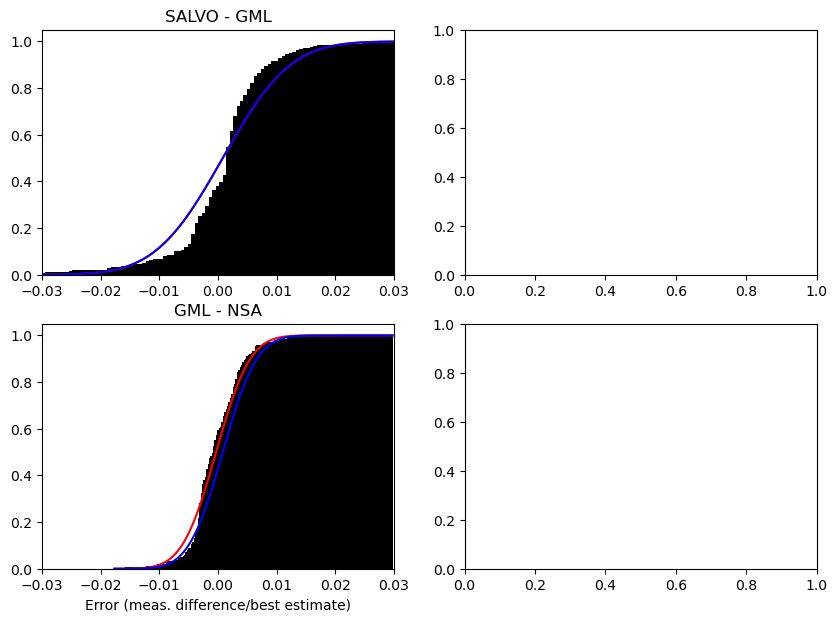

In [66]:
# Create figure comparing normalized incident distributions
f, axs = plt.subplots(2, 2, sharex=False, figsize=(10, 7))

cts, bins, _ = axs[0, 0].hist(df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2'], bins=200, color='k',
                          density=True, cumulative=True)
axs[0, 0].plot(bins, norm.cdf(bins, loc=mn_gml_ratio, scale=std_gml_ratio), c='r')
axs[0, 0].plot(bins, norm.cdf(bins, loc=mn_gml_ratio, scale=
                           (df_comp_clean['diff_gml_be']/df_comp_clean['mean_incident_W_m2']).std()),
            color='b')
axs[0, 0].set_xlim([-0.03, 0.03])
axs[0, 0].set_title('SALVO - GML')

cts, bins, _ = axs[1, 0].hist(df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2'], bins=200, color='k',
                          density=True, cumulative=True)
axs[1, 0].plot(bins, norm.cdf(bins, loc=mn_gml_nsa_ratio, scale=std_gml_nsa_ratio), c='r')
axs[1, 0].plot(bins, norm.cdf(bins, loc=mn_gml_ratio, scale=
                           (df_comp_clean['diff_gml_nsa']/df_comp_clean['mean_incident_W_m2']).std()),
            color='b')
axs[1, 0].set_xlim([-0.03, 0.03])
axs[1, 0].set_title('GML - NSA')

axs[1, 0].set_xlabel('Error (meas. difference/best estimate)')
#f.supylabel('Cumulative density function')
#f.savefig(os.path.join('..', 'figures', 'salvo_arm_inc_err.png'), bbox_inches='tight')

In [67]:
df_comp_clean

,salvo_arm_incident,incident_solar_W_m2,incident_bestestimate_W_m2,direct_solar_W_m2,diffuse_solar_W_m2,zen,nsa_incident,diff_gml_be,diff_nsa,diff_gml,diff_gml_nsa,diffuse_frac,mean_incident_W_m2
timestamp_akdt,,,,,,,,,,,,,
2024-04-19 13:07:00-08:00,349.75,340.608382,340.608382,-0.6,340.9,60.92,341.686493,9.141618,8.063507,9.141618,-1.078111,1.000856,1032.044875
2024-04-19 13:10:00-08:00,358.98,350.894961,350.894961,0.4,350.7,60.83,355.094574,8.085039,3.885426,8.085039,-4.199613,0.999444,1064.969535
2024-04-19 13:11:00-08:00,367.09,360.456295,360.456295,3.6,358.7,60.80,366.541321,6.633705,0.548679,6.633705,-6.085026,0.995128,1094.087616
2024-04-19 13:12:00-08:00,378.83,369.525465,369.525465,2.1,368.5,60.77,375.153137,9.304535,3.676863,9.304535,-5.627672,0.997225,1123.508602
2024-04-19 13:13:00-08:00,382.19,376.188774,376.188774,1.0,375.7,60.74,380.659943,6.001226,1.530057,6.001226,-4.471169,0.998701,1139.038716
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17 13:22:00-08:00,298.76,296.882972,296.882972,2.1,295.5,48.81,303.654480,1.877028,-4.894480,1.877028,-6.771508,0.995342,899.297452
2024-06-17 13:23:00-08:00,303.42,299.976462,299.976462,3.0,298.0,48.79,304.994873,3.443538,-1.574873,3.443538,-5.018411,0.993411,908.391335
2024-06-17 13:23:00-08:00,300.76,299.976462,299.976462,3.0,298.0,48.79,304.994873,0.783538,-4.234873,0.783538,-5.018411,0.993411,905.731335


## Plot potential bias as a function of albedo and incident irradiance

In [104]:
df.xs('incident_solar_W_m2', level='variable').quantile([0.05, 0.2])


,value
0.05,301.764
0.20,415.340


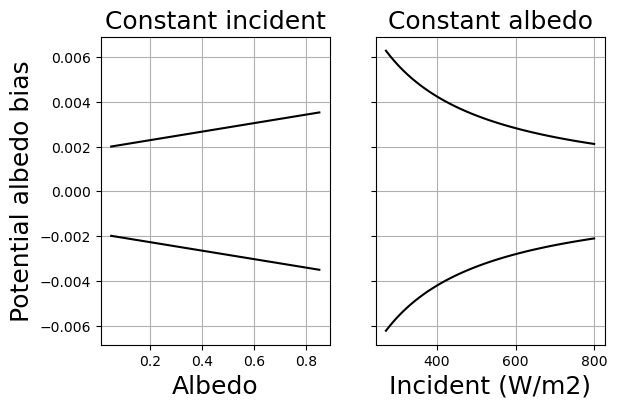

In [115]:
fs = 18

bias = 1.03
const_alb = 0.64
const_inc = 542.0
albs = np.linspace(0.05, 0.85)
incs = np.linspace(270.0, 800.0)

var_alb_ref = albs * const_inc
bias_alb_minus = ((var_alb_ref - bias)/(const_inc + bias)) - albs
bias_alb_plus = ((var_alb_ref + bias)/(const_inc - bias)) - albs

var_inc_ref = const_alb * incs
bias_inc_minus = ((var_inc_ref - bias)/(incs + bias)) - const_alb
bias_inc_plus = ((var_inc_ref + bias)/(incs - bias)) - const_alb

f, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 4))

axs[0].plot(albs, bias_alb_plus, 'k')
axs[0].plot(albs, bias_alb_minus, 'k')
axs[0].set_xlabel('Albedo', fontsize=fs)
axs[0].grid()
axs[0].set_title('Constant incident', fontsize=fs)

axs[1].plot(incs, bias_inc_plus, 'k')
axs[1].plot(incs, bias_inc_minus, 'k')
axs[1].set_xlabel('Incident (W/m2)', fontsize=fs)
axs[1].grid()
axs[1].set_title('Constant albedo', fontsize=fs)

axs[0].set_ylabel('Potential albedo bias', fontsize=fs)

f.savefig(os.path.join('..', 'figures', 'salvo_pot_alb_bias.png'), bbox_inches='tight')


In [105]:
bias_inc_minus

array([-0.00623252, -0.00599334, -0.00577183, -0.00556612, -0.00537456,
       -0.00519575, -0.00502846, -0.0048716 , -0.00472423, -0.00458552,
       -0.00445472, -0.00433118, -0.0042143 , -0.00410356, -0.0039985 ,
       -0.00389868, -0.00380372, -0.00371328, -0.00362704, -0.00354472,
       -0.00346605, -0.00339079, -0.00331873, -0.00324968, -0.00318343,
       -0.00311984, -0.00305873, -0.00299998, -0.00294344, -0.00288899,
       -0.00283651, -0.00278591, -0.00273709, -0.00268994, -0.00264439,
       -0.00260036, -0.00255777, -0.00251656, -0.00247665, -0.00243799,
       -0.00240051, -0.00236417, -0.00232892, -0.0022947 , -0.00226147,
       -0.00222919, -0.00219782, -0.00216732, -0.00213765, -0.00210878])

In [106]:
incs

array([270.        , 280.81632653, 291.63265306, 302.44897959,
       313.26530612, 324.08163265, 334.89795918, 345.71428571,
       356.53061224, 367.34693878, 378.16326531, 388.97959184,
       399.79591837, 410.6122449 , 421.42857143, 432.24489796,
       443.06122449, 453.87755102, 464.69387755, 475.51020408,
       486.32653061, 497.14285714, 507.95918367, 518.7755102 ,
       529.59183673, 540.40816327, 551.2244898 , 562.04081633,
       572.85714286, 583.67346939, 594.48979592, 605.30612245,
       616.12244898, 626.93877551, 637.75510204, 648.57142857,
       659.3877551 , 670.20408163, 681.02040816, 691.83673469,
       702.65306122, 713.46938776, 724.28571429, 735.10204082,
       745.91836735, 756.73469388, 767.55102041, 778.36734694,
       789.18367347, 800.        ])